In [2]:
import numpy as np 
import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import datetime
from sklearn.decomposition import PCA, KernelPCA
from numpy import linalg as LA
import plotly.graph_objs as go
import plotly.colors as colors
from linear_sca import *
from utils import *
import wandb
from itertools import combinations

In [5]:
X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/Churchland/churchland.npy') 
X = jnp.array(X) 
K, N, T = X.shape
print(X.shape)

(108, 218, 61)


In [6]:

X, _ = pre_processing(X, soft_normalize='max')
X = X.swapaxes(1,2)
print(X.shape)
print(compute_S_all_pairs(X))

(108, 61, 30)
0.4426879


In [7]:

wandb.init(project="SCA-project", name="run_1", mode="disabled")
optimized_params, ls_loss, ls_S_ratio = optimize(X[10:], d=3, iterations=5000, learning_rate=0.01) # iterations, learning_rate, d               
wandb.finish()



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Iteration 0, S: 0.05406546592712402, S_ratio: 0.32056257128715515
Iteration 10, S: 0.3151222765445709, S_ratio: 0.3748079240322113
Iteration 20, S: 0.6827066540718079, S_ratio: 0.37310948967933655
Iteration 30, S: 1.5191047191619873, S_ratio: 0.36476990580558777
Iteration 40, S: 3.797510862350464, S_ratio: 0.3556109070777893
Iteration 50, S: 6.7383575439453125, S_ratio: 0.34967097640037537
Iteration 60, S: 11.892693519592285, S_ratio: 0.34641018509864807
Iteration 70, S: 15.1354341506958, S_ratio: 0.34987905621528625
Iteration 80, S: 17.954212188720703, S_ratio: 0.3461343050003052
Iteration 90, S: 23.403209686279297, S_ratio: 0.3834576904773712
Iteration 100, S: 22.983234405517578, S_ratio: 0.34856265783309937
Iteration 110, S: 34.70848083496094, S_ratio: 0.3776535093784332
Iteration 120, S: 20.70240592956543, S_ratio: 0.33801013231277466
Iteration 130, S: 38.72846603393555, S_ratio: 0.38333749771118164
Iteration 140, S: 39.338340759277344, S_ratio: 0.3516431748867035
Iteration 150, S:

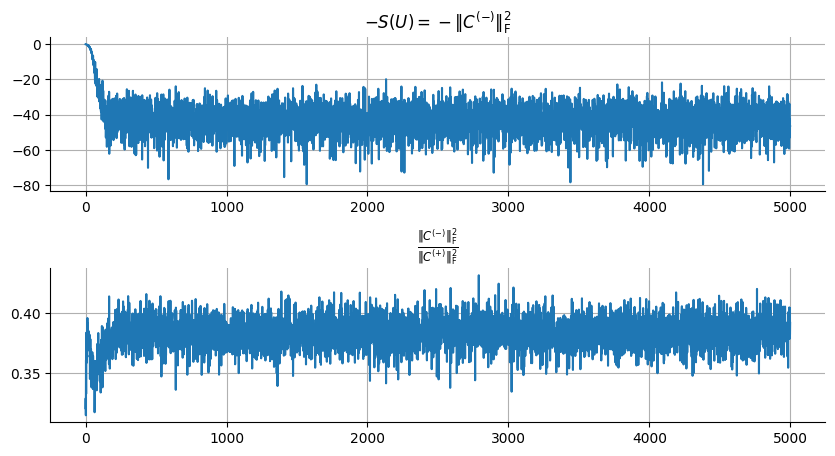

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(ls_loss)
plt.grid()
plt.title(r"$-S(U) = -\|C^{(-)}\|_\mathrm{F}^2$")
plt.gca().spines[['top','right']].set_visible(False)
plt.subplot(212)
plt.plot(ls_S_ratio)
plt.title(r"$\frac{\|C^{(-)}\|_\mathrm{F}^2}{\|C^{(+)}\|_\mathrm{F}^2}$")
plt.gca().spines[['top','right']].set_visible(False)
plt.grid()
plt.subplots_adjust(hspace=0.5)


0.3842282


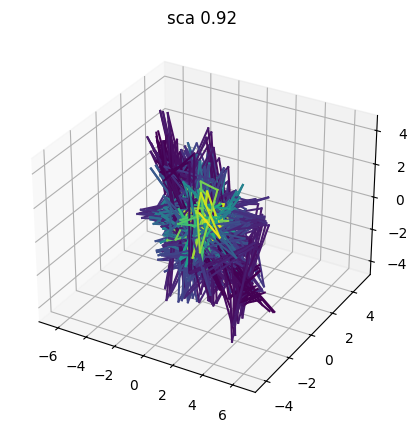

In [9]:
U = optimized_params
# s_normalized = jnp.sqrt(X.shape[1]) * (s ** 2) / jnp.linalg.norm(s ** 2)
# X_scaled = s_normalized[None, :, None] *  X

U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr[:,:], X[10:,:,:])         #(K,d,T) 

plot_3D(Y[:,:,:])
plt.title(f"sca {var_explained(X[10:], U_qr):.2f}")

#Set the axis limits
# min = -7
# max = 7
# ax.set_xlim([min, max])
# ax.set_ylim([min, max])
# ax.set_zlim([min, max])
print(np.mean(compute_S(Y)))

In [ ]:
def make_frame(angle):
    ax.view_init(angle, 30)
    fig.canvas.draw() 
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image

angles = range(0,360, 2) 
frames = [make_frame(angle) for angle in angles]

#gif_path = date_time_str + "_trajectories_rotation.gif"
gif_path = "trajectories_rotation.gif"
imageio.mimsave(gif_path, frames, fps=20)


gif_path

In [9]:
fig = go.Figure()
num_time_points = Y.shape[-1]
indices_to_plot = np.arange(0,Y.shape[0],1)

for i in indices_to_plot:
    x = Y[i, 0, :]
    y = Y[i, 1, :]
    z = Y[i, 2, :]

    for t in range(num_time_points - 1):
        color_scale = colors.sequential.Viridis
        color_index = int(t / (num_time_points - 1) * (len(color_scale) - 1))
        fig.add_trace(go.Scatter3d(
            x=x[t:t+2],
            y=y[t:t+2],
            z=z[t:t+2],
            mode='lines',
            line=dict(color=color_scale[color_index]),
            showlegend=False
        ))

# fig.update_layout(
#     scene=dict(
#         xaxis=dict(title='X', range=[min, max]),
#         yaxis=dict(title='Y', range=[-0.5, 0.5]),
#         zaxis=dict(title='Z', range=[min, max])
#     )
# )

fig.show()

ENDS HERE 